In [1]:
# *******************************************************************
#      Comenzaremos cargando los paquetes que se necesitan
# *******************************************************************
import copy
import random
import sys 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import yfinance as yf 
%matplotlib inline
plt.style.use('ggplot') 
import seaborn as sns

def ventana_deslizante(ts, longitud):
    X = []
    Y = []

    for i in range(longitud + 1, len(ts) + 1):
        X.append(ts[i - (longitud + 1):i - 1])
        Y.append([ts[i - 1]])

    return X, Y
# Función para obtener la serie de tiempo (ts)
def ob_serie_tiempo():
    #inicio = '1994-1-1'
    #fin = '2022-1-1' #
    #df = yf.download('^GSPC',start=inicio,end=fin)
    #df = pd.read_csv('AEP_hourly.csv')
    #df['diff_2'] = df['diff_1'].diff()
    df = pd.read_csv('SP500_Datos.csv')
    ts = df['y'].astype(int).values.reshape(-1,1)[-7000:]
    return ts

# Función para obtener los datos de entrenamiento 
def obt_datos_entrenamiento(ts,longitud,long_test):
    X,Y = ventana_deslizante(ts,longitud)
    
    X_entr, Y_entr, X_prueb, Y_prueb = X[0:-long_test],\
                                       Y[0:-long_test],\
                                       X[-long_test:],\
                                       Y[-long_test:]
                                       
    long_entr = round(len(ts)*0.7)
    
    X_entr, X_val, Y_entr, Y_val = X_entr[0:long_entr],\
                                   X_entr[long_entr:],\
                                   Y_entr[0:long_entr],\
                                   Y_entr[long_entr:]
                                   
    x_entr = torch.tensor(data = X_entr).float()
    y_entr = torch.tensor(data = Y_entr).float()
    
    x_val = torch.tensor(data = X_val).float()
    y_val = torch.tensor(data = Y_val).float()
    
    x_prueb = torch.tensor(data = X_prueb).float()
    y_prueb = torch.tensor(data = Y_prueb).float()
    
    return x_entr, x_val, x_prueb,\
           y_entr.squeeze(1), y_val.squeeze(1), y_prueb.squeeze(1)

In [2]:
import torch.nn as nn

class RNN(nn.Module):

    def __init__(self,
                 hidden_size,
                 in_size = 1,
                 out_size = 1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size = in_size,
            hidden_size = hidden_size,
            batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)
        
    def forward(self, x, h = None):
        out, _ = self.rnn(x, h)
        last_hidden_states = out[:, -1]
        out = self.fc(last_hidden_states)
        return out, last_hidden_states

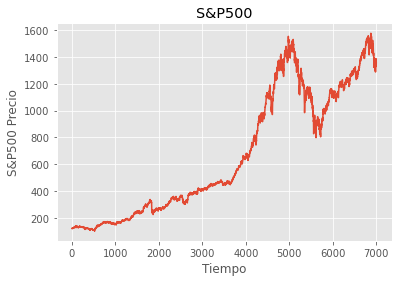

In [3]:
plt.title('S&P500')
plt.ylabel('S&P500 Precio')
plt.xlabel('Tiempo')
plt.plot(ob_serie_tiempo())
plt.show()

In [68]:
len(ob_serie_tiempo())

7000

In [43]:
# PARAMETROS

# Longitud de la ventana deslizante
longitud = 240

# Longitud del conjunto de datos de prueba
long_ts_prueba = 300

# Tamaños ocultos de capas
tam_oculto_cap = 24

# Tasa de aprendizaje 
tasa_aprendizaje = 0.03

# Epocas
epochs_entrenamiento = 500

In [44]:
# Preparando conjunto de datos para entrenamiento
ts = ob_serie_tiempo()
scalador = MinMaxScaler()
scalador_ts = scalador.fit_transform(ts)
x_entr, x_val, x_prueb, y_entr, y_val, y_prueb = obt_datos_entrenamiento(scalador_ts,longitud,long_ts_prueba)
print(len(x_entr), ': datos de entrenamiento ');
print(len(x_prueb), ': datos de prueba ');

4900 : datos de entrenamiento 
300 : datos de prueba 


In [45]:
modelo = RNN(hidden_size=tam_oculto_cap)
modelo.train()

RNN(
  (rnn): RNN(1, 24, batch_first=True)
  (fc): Linear(in_features=24, out_features=1, bias=True)
)

In [46]:
random.seed(1)
torch.manual_seed(1)

# ENTRENAMIENTO
optimizador  =torch.optim.Adam(params=modelo.parameters(),lr=tasa_aprendizaje)
mse_loss = torch.nn.MSELoss()

best_model = None
min_val_loss = sys.maxsize

Entrenamiento_loss = []
validacion_loss = []

for epoch in range(epochs_entrenamiento):
    prediction, _ = modelo(x_entr)
    loss = mse_loss(prediction,y_entr)
    
    optimizador.zero_grad()
    loss.backward()
    optimizador.step()
    
    val_prediction, _ = modelo(x_val)
    val_loss = mse_loss(val_prediction,y_val)
    
    Entrenamiento_loss.append(loss.item())
    validacion_loss.append(val_loss.item())
    
    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(modelo)
        min_val_loss = val_loss.item()
        
    if epoch % 50 == 0:
        print(f'epoch {epoch} - '
              
              f'Loss = {round(val_loss.item(), 6)}')
        
best_model.eval()
_, h_list = best_model(x_val)

epoch 0 - Loss = 0.0468
epoch 50 - Loss = 0.037832
epoch 100 - Loss = 0.000148
epoch 150 - Loss = 4.5e-05
epoch 200 - Loss = 4.9e-05
epoch 250 - Loss = 5e-05
epoch 300 - Loss = 5e-05
epoch 350 - Loss = 5e-05
epoch 400 - Loss = 5e-05
epoch 450 - Loss = 5e-05


In [47]:
# Estado Oculto
h = (h_list[-1, :]).unsqueeze(-2)

predicted = []
for test_seq in x_prueb.tolist():
    x = torch.Tensor(data = [test_seq])
    # pasando el estado oculto a través de cada iteración
    y, h = best_model(x, h.unsqueeze(-2))
    unscaled = scalador.inverse_transform(np.array(y.item()).reshape(-1, 1))[0][0]
    predicted.append(unscaled)
real = scalador.inverse_transform(y_prueb.tolist())

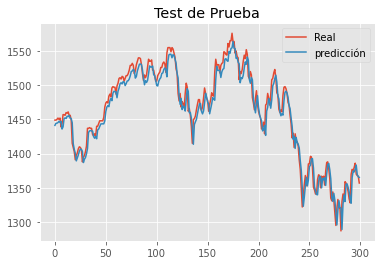

In [48]:
plt.title("Test de Prueba")
plt.plot(real, label = 'Real')
plt.plot(predicted, label = 'predicción')
plt.legend()
plt.show()

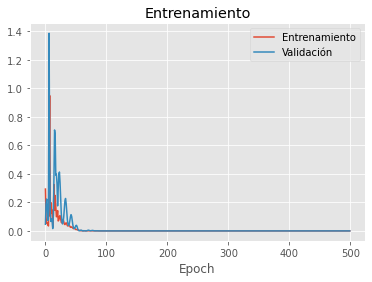

In [49]:
plt.title('Entrenamiento')
plt.plot(Entrenamiento_loss, label='Entrenamiento')
plt.plot(validacion_loss, label='Validación')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [50]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print("MSE: ", mean_squared_error(predicted,real))
print("MAE: ", mean_absolute_error(predicted,real))
print("PPA: ", np.mean(real))


MSE:  188.20379879240534
MAE:  10.876164365410814
PPA:  1460.8766694575547
